In [6]:
import sqlite3
import pandas as pd
import gensim
import numpy as np
import matplotlib.pyplot as plt
from time import time
from sklearn.cluster import KMeans
from sklearn import metrics
import os

In [15]:
# obsolete

#cx = sqlite3.connect('/home/wsyj/dissertation__imdb/005_scrapy_hello/tutorial/tutorial/spiders/my_db.db')

In [2]:
# load word2vec model
model_path = '/home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=100_min_count=1_window=1_iter=30.model'

#model = gensim.models.Word2Vec.load('/home/wsyj/dissertation__recommendation_system__experiment_2/dissertation__recommendation_system__experiment/main_modelnum_features=200_min_count=5_window=2.model' )
model = gensim.models.Word2Vec.load(model_path)

In [16]:
# obsolete

#cur.execute('select distinct(item_id) from items_with_synopsis')
#r = cur.fetchall()
#r = [x[0] for x in r]

In [34]:
obsolete

vec_list = []
for item in r:
    key = str(item)
    if key not in model:
        continue
    vec_list.append(model[key])
data = np.array(vec_list    )

In [3]:
vec_list = []
for key in model.vocab:
    vec_list.append(model[key])
data = np.array(vec_list)

In [4]:
obsolete

# get all genres
cur = cx.cursor()

cur.execute('select genres from genres_of_items_with_synopsis')

ret = cur.fetchall()
len(ret)
#442
ret = [x[0] for x in ret]
len(ret)
#442
ret[0]
ret = ','.join(ret)
ret = ret.split(',')
len(ret)
#1300
len(set(ret))
#21
all_genres = set(ret)
all_genres = list(all_genres)
all_genres.sort()

print all_genres

In [4]:
all_genres = ["Action",
"Adventure",
"Animation",
"Children's",
"Comedy",
"Crime",
"Documentary",
"Drama",
"Fantasy",
"Film-Noir",
"Horror",
"Musical",
"Mystery",
"Romance",
"Sci-Fi",
"Thriller",
"War",
"Western",]

In [8]:
def extract_genres(filename, delimiter, genre_delimiter):
    data = {}

    with open(filename , 'r') as f:
        for i, line in enumerate(f):
            itemId, title, genre_list = map(lambda x: x.strip(), line.split(delimiter))
            
            data[itemId] = genre_list.split(genre_delimiter)
    return data


item_file_name, item_file_delimiter, genre_delimiter = os.path.sep.join(['ml-1m', 'movies.dat']), '::', '|'
item_info = extract_genres(item_file_name, item_file_delimiter, genre_delimiter)

In [31]:


# find out genres of items in a cluster
def find_out_genres_of_items_in_a_cluster(cluster_label, y_pred, model):
    c = data[y_pred == cluster_label]
    
    item_genres_list = []
    for member in c:
        item_id, simi = model.most_similar([member], topn=1)[0]
        assert(simi > 0.99999)
        
        #cur.execute('select genres from genres_of_items_with_synopsis where item_id = %s' % item_id)
        #ret = cur.fetchall()
        #ret = [x[0] for x in ret]
        #assert(1 == len(ret))
        #
        #item_genres_list.append((item_id, ret))
        
        item_genres_list.append((item_id, [','.join(item_info[item_id])]))
    return item_genres_list



In [10]:
# find out genre distribution for items belonging to a single cluster
def find_genre_dist(item_genres_list):
    #print item_genres_list
    dist_dist = reduce(lambda x, y: (None, x[1] + y[1]), item_genres_list)
    dist_dist = dist_dist[1]
    dist_dist = [x.split(',') for x in dist_dist]
    dist_dist = reduce(lambda x, y: x + y, dist_dist)
    
    genre_set = set(dist_dist)
    genre_unique_list = list(genre_set)
    
    dist = [(x, list(dist_dist).count(x)) for x in genre_unique_list]
    dist.sort(key=lambda x: -1 * x[1])
    
    return dist

In [11]:
def bench_k_means(estimator, name, data, sample_size=300):
    t0 = time()
    estimator.fit(data)

    print('% 9s   %.2fs    %.3f'
          % (name, (time() - t0), 
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)
))
    
    y_pred = estimator.predict(data)
    return y_pred

In [47]:
pred_result_map = {}
score_map = {}
prm = pred_result_map
sample_size = 300
#for n_digits in range(51, 91):
for n_digits in range(38, 47):
#for n_digits in range(31, 51):
#for n_digits in range(15, 31):
#for n_digits in range(2, 15):
    name = 'k-means++'
    t0 = time()
    estimator = KMeans(init=name, n_clusters=n_digits, n_init=100)
    estimator.fit(data)
    
    silhouette_score = metrics.silhouette_score(data, estimator.labels_, metric='euclidean', sample_size=sample_size)
    print('n_digits=%d   % 9s   %.2fs    %.3f' % (n_digits, name, (time() - t0), silhouette_score))
    prm[n_digits] = estimator.labels_
    score_map[n_digits] = silhouette_score

'''
1M:

n_digits=2   k-means++   3.88s    0.037    0.037
n_digits=3   k-means++   4.65s    0.028    0.035
n_digits=4   k-means++   5.23s    0.042    0.044
n_digits=5   k-means++   5.54s    0.053    0.053
n_digits=6   k-means++   6.12s    0.055    0.055
n_digits=7   k-means++   6.15s    0.054    0.057
n_digits=8   k-means++   6.26s    0.070    0.059
n_digits=9   k-means++   6.59s    0.066    0.071
n_digits=10   k-means++   6.56s    0.071    0.067
n_digits=11   k-means++   6.49s    0.075    0.068
n_digits=12   k-means++   6.90s    0.076    0.077
n_digits=13   k-means++   6.82s    0.089    0.076
n_digits=14   k-means++   7.07s    0.085    0.086
n_digits=15   k-means++   6.86s    0.080

n_digits=16   k-means++   7.28s    0.094
n_digits=17   k-means++   7.72s    0.089
n_digits=18   k-means++   7.46s    0.090
n_digits=19   k-means++   7.58s    0.095
n_digits=20   k-means++   7.51s    0.093
n_digits=21   k-means++   8.14s    0.083
n_digits=22   k-means++   8.21s    0.103
n_digits=23   k-means++   8.23s    0.089
n_digits=24   k-means++   8.13s    0.115
n_digits=25   k-means++   8.56s    0.109
n_digits=26   k-means++   8.65s    0.113
n_digits=27   k-means++   8.58s    0.103
n_digits=28   k-means++   8.58s    0.105
n_digits=29   k-means++   9.17s    0.107
n_digits=30   k-means++   9.44s    0.100

n_digits=31   k-means++   9.10s    0.114    0.114
n_digits=32   k-means++   9.33s    0.120    0.087
n_digits=33   k-means++   9.39s    0.111    0.113
n_digits=34   k-means++   9.86s    0.111    0.116
n_digits=35   k-means++   9.69s    0.113    0.112
n_digits=36   k-means++   10.15s    0.123    0.108
n_digits=37   k-means++   10.02s    0.128    0.110
n_digits=38   k-means++   10.28s    0.107    0.110
n_digits=39   k-means++   10.69s    0.119    0.127
n_digits=40   k-means++   10.45s    0.114    0.109
n_digits=41   k-means++   10.86s    0.108    0.108
n_digits=42   k-means++   10.91s    0.139    0.118
n_digits=43   k-means++   11.24s    0.113    0.113
n_digits=44   k-means++   11.12s    0.118
n_digits=45   k-means++   11.43s    0.107
n_digits=46   k-means++   12.03s    0.110
n_digits=47   k-means++   11.40s    0.114
n_digits=48   k-means++   11.75s    0.114
n_digits=49   k-means++   12.11s    0.105
n_digits=50   k-means++   12.45s    0.109

n_digits=51   k-means++   13.07s    0.110
n_digits=52   k-means++   12.67s    0.121
n_digits=53   k-means++   13.02s    0.127
n_digits=54   k-means++   13.27s    0.121
n_digits=55   k-means++   13.35s    0.101
n_digits=56   k-means++   13.07s    0.125
n_digits=57   k-means++   13.40s    0.114
n_digits=58   k-means++   13.50s    0.126
n_digits=59   k-means++   13.50s    0.127
n_digits=60   k-means++   13.75s    0.108
n_digits=61   k-means++   14.26s    0.101
n_digits=62   k-means++   14.27s    0.122
n_digits=63   k-means++   14.27s    0.114
n_digits=64   k-means++   14.22s    0.115
n_digits=65   k-means++   14.28s    0.102
n_digits=66   k-means++   14.58s    0.102
n_digits=67   k-means++   16.68s    0.114
n_digits=68   k-means++   16.74s    0.090
n_digits=69   k-means++   15.77s    0.104
n_digits=70   k-means++   17.07s    0.121
n_digits=71   k-means++   15.93s    0.107
n_digits=72   k-means++   16.52s    0.107
n_digits=73   k-means++   16.92s    0.110
n_digits=74   k-means++   15.63s    0.095
n_digits=75   k-means++   15.82s    0.105
n_digits=76   k-means++   15.77s    0.111
n_digits=77   k-means++   16.23s    0.099
n_digits=78   k-means++   15.94s    0.094

'''


0

n_digits=38   k-means++   11.35s    0.116
n_digits=39   k-means++   10.69s    0.107
n_digits=40   k-means++   11.02s    0.108
n_digits=41   k-means++   11.23s    0.111
n_digits=42   k-means++   11.27s    0.113
n_digits=43   k-means++   11.50s    0.114
n_digits=44   k-means++   11.86s    0.114
n_digits=45   k-means++   11.77s    0.088
n_digits=46   k-means++   11.78s    0.104


0

In [23]:
0

0

In [26]:
len(data)

420

In [27]:
len(prm[2])

420

In [32]:
np.arange(5)

array([0, 1, 2, 3, 4])

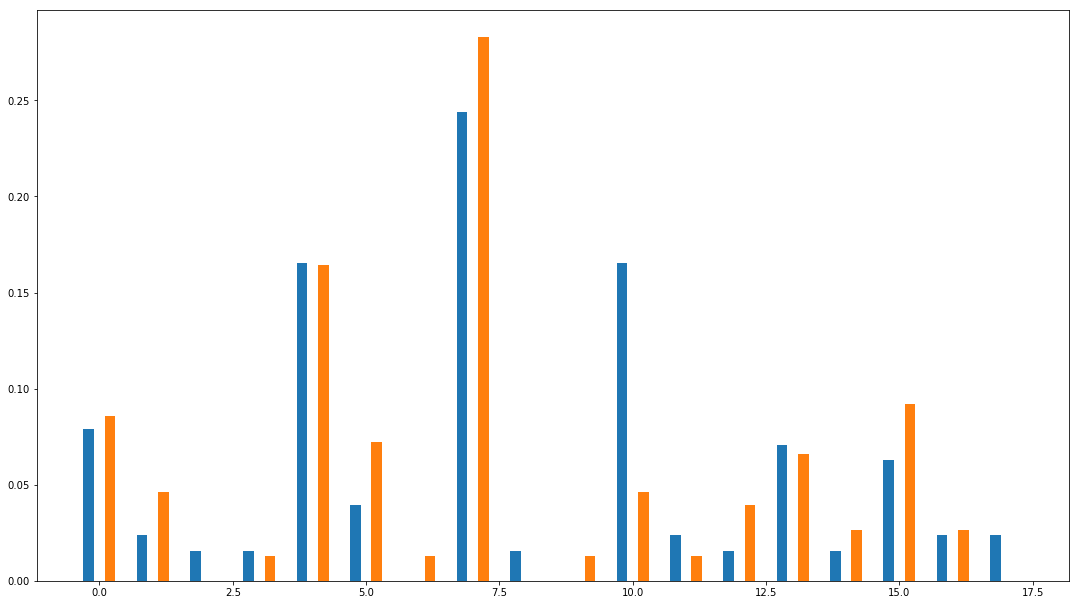

In [52]:
igl_0 = find_out_genres_of_items_in_a_cluster(0, prm[42], model) 
igl_1 = find_out_genres_of_items_in_a_cluster(1, prm[42], model)

gd0 = find_genre_dist(igl_0)
gd1 = find_genre_dist(igl_1)
d0 = dict(gd0)
d1 = dict(gd1)

for g in all_genres:
        if g not in d0:
            d0[g] = 0
for g in all_genres:
        if g not in d1:
            d1[g] = 0
assert(set(d0.keys()) == set(d1.keys()))

d0_list = [d0[x] for x in all_genres]
d1_list = [d1[x] for x in all_genres]

d0_list_copy = d0_list[:]
d0_list = np.array(d0_list) * 1. / sum(d0_list)

d1_list_copy = d1_list[:]
d1_list = np.array(d1_list) * 1. / sum(d1_list)

indexes = np.arange(len(all_genres))

plt.bar(indexes - 0.2, d0_list, 0.2)
plt.bar(indexes + 0.2, d1_list, 0.2)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)

plt.show()

In [46]:
np.random.rand(10, 4)

array([[ 0.99321386,  0.75671044,  0.30852014,  0.88138383],
       [ 0.9018056 ,  0.83133961,  0.85739764,  0.11274636],
       [ 0.17011929,  0.04722505,  0.32742641,  0.09792062],
       [ 0.8520923 ,  0.59405983,  0.25410066,  0.60249242],
       [ 0.89672469,  0.75811936,  0.56734156,  0.4017995 ],
       [ 0.71067348,  0.65310533,  0.91731789,  0.75193156],
       [ 0.40863394,  0.99321166,  0.15616005,  0.7209536 ],
       [ 0.58074293,  0.60950924,  0.05539113,  0.87947365],
       [ 0.82367301,  0.72787372,  0.72459668,  0.69413191],
       [ 0.88005554,  0.35739363,  0.7782555 ,  0.03277105]])

In [51]:
print d0_list
print d1_list

tmp = zip(d0_list, d1_list)
print tmp

[ 0.09333333  0.04888889  0.00888889  0.00888889  0.08444444  0.09333333
  0.18666667  0.03111111  0.02666667  0.          0.01333333  0.03111111
  0.00888889  0.01333333  0.06222222  0.05333333  0.06222222  0.
  0.14666667  0.02222222  0.00444444]
[ 0.07079646  0.06293019  0.01376598  0.02163225  0.12291052  0.06686332
  0.1927237   0.03441495  0.04228122  0.00589971  0.01376598  0.03048181
  0.00983284  0.01769912  0.03048181  0.08652901  0.04818092  0.00589971
  0.093412    0.0186824   0.01081613]
[(0.093333333333333338, 0.070796460176991149), (0.048888888888888891, 0.062930186823992137), (0.0088888888888888889, 0.01376597836774828), (0.0088888888888888889, 0.021632251720747297), (0.084444444444444447, 0.12291052114060963), (0.093333333333333338, 0.066863323500491637), (0.18666666666666668, 0.1927236971484759), (0.03111111111111111, 0.0344149459193707), (0.026666666666666668, 0.042281219272369712), (0.0, 0.0058997050147492625), (0.013333333333333334, 0.01376597836774828), (0.0311111

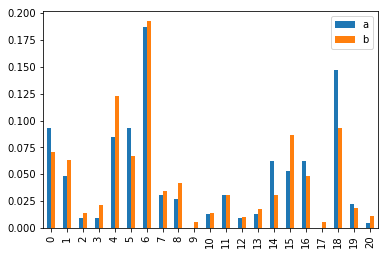

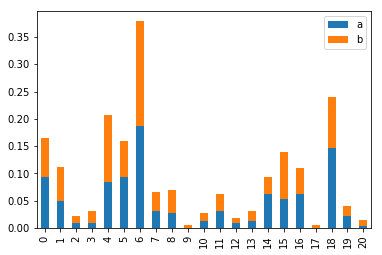

In [53]:

df2 = pd.DataFrame(tmp, columns=['a', 'b'])

df2.plot.bar()
    
df2.plot.bar(stacked=True)

plt.show()

In [ ]:
5

In [21]:
print all_genres

['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


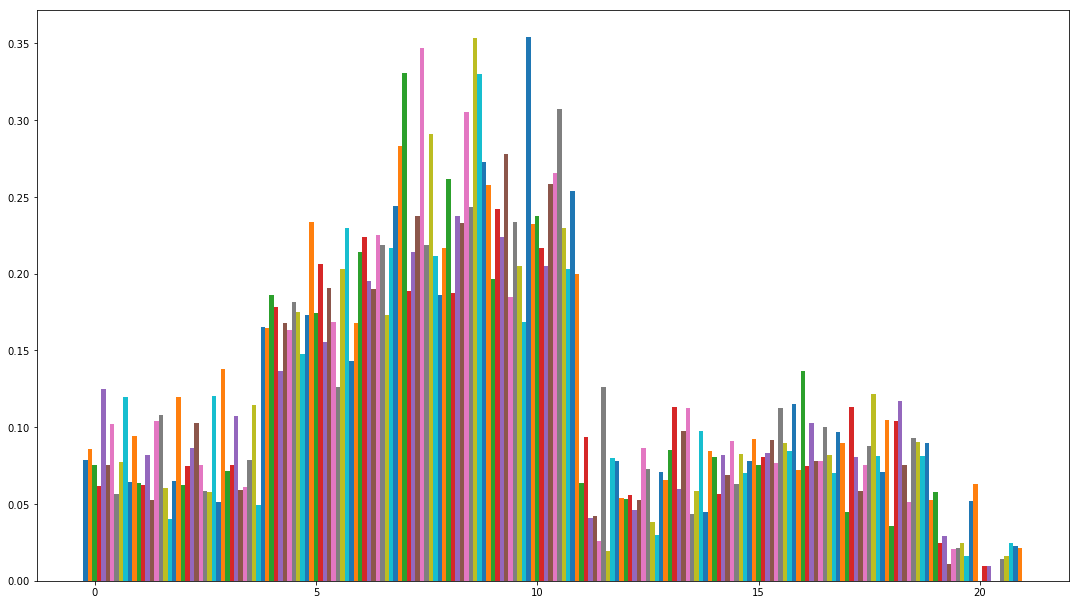

In [50]:
# plot
#
#   for each genre @g, plot num_of_clusters bars, each bar representing how 
# often genre @g appears in that cluster in percentage.
#
# caveat: too big number of clusters might lead to overlap

interested_k = 42

item_genres_list__list = [find_out_genres_of_items_in_a_cluster(x, prm[interested_k], model) for x in xrange(interested_k)]

genre_dist_list = [find_genre_dist(igl) for igl in item_genres_list__list]

d_dict_list = [dict(gd) for gd in genre_dist_list]

for d in d_dict_list:
    for g in all_genres:
        if g not in d:
            d[g] = 0
for i in xrange(len(d_dict_list)):
    for j in xrange(i):
        #print d_dict_list[i].keys()
        #print d_dict_list[j].keys()
        assert(set(d_dict_list[i].keys()) == set(d_dict_list[j].keys()))

d_list_list = [[d[x] for x in all_genres] for d in d_dict_list]

d_list_list = [np.array(d_list) * 1. / sum(d_list) for d_list in d_list_list]


indexes = np.arange(len(all_genres))

for i, d_list in enumerate(d_list_list):
    plt.bar(indexes - 0.2 + 0.1 * i, d_list, 0.1)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)

plt.show()


In [73]:
all_genres

[u'Action',
 u'Adventure',
 u'Animation',
 u'Biography',
 u'Comedy',
 u'Crime',
 u'Drama',
 u'Family',
 u'Fantasy',
 u'Film-Noir',
 u'History',
 u'Horror',
 u'Music',
 u'Musical',
 u'Mystery',
 u'Romance',
 u'Sci-Fi',
 u'Sport',
 u'Thriller',
 u'War',
 u'Western']

[(0.07874015748031496, 0.085526315789473686, 0.075376884422110546, 0.061643835616438353, 0.125, 0.07567567567567568, 0.10204081632653061, 0.056250000000000001, 0.077669902912621352, 0.11971830985915492, 0.064102564102564097, 0.094444444444444442, 0.063492063492063489, 0.0625, 0.081967213114754092, 0.052910052910052907, 0.1038961038961039, 0.10810810810810811, 0.060150375939849621, 0.040000000000000001, 0.064935064935064929, 0.11976047904191617, 0.0625, 0.074534161490683232, 0.086206896551724144, 0.1024390243902439, 0.075144508670520235, 0.058394160583941604, 0.057692307692307696, 0.12048192771084337, 0.044247787610619468, 0.13812154696132597, 0.0071942446043165471, 0.075471698113207544, 0.10731707317073171, 0.059139784946236562, 0.061224489795918366, 0.07857142857142857, 0.11475409836065574, 0.04878048780487805, 0.067164179104477612, 0.10526315789473684), (0.023622047244094488, 0.046052631578947366, 0.040201005025125629, 0.047945205479452052, 0.047619047619047616, 0.043243243243243246,

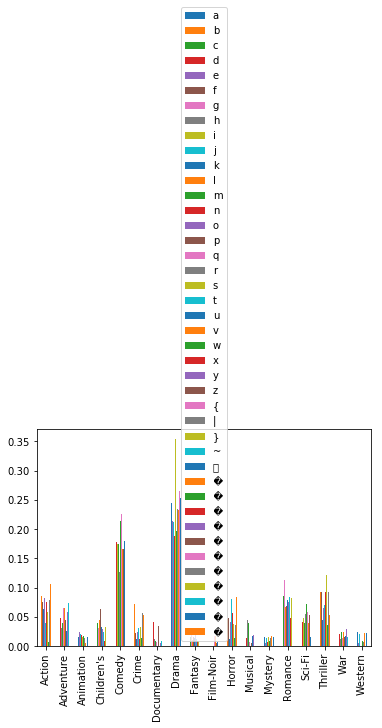

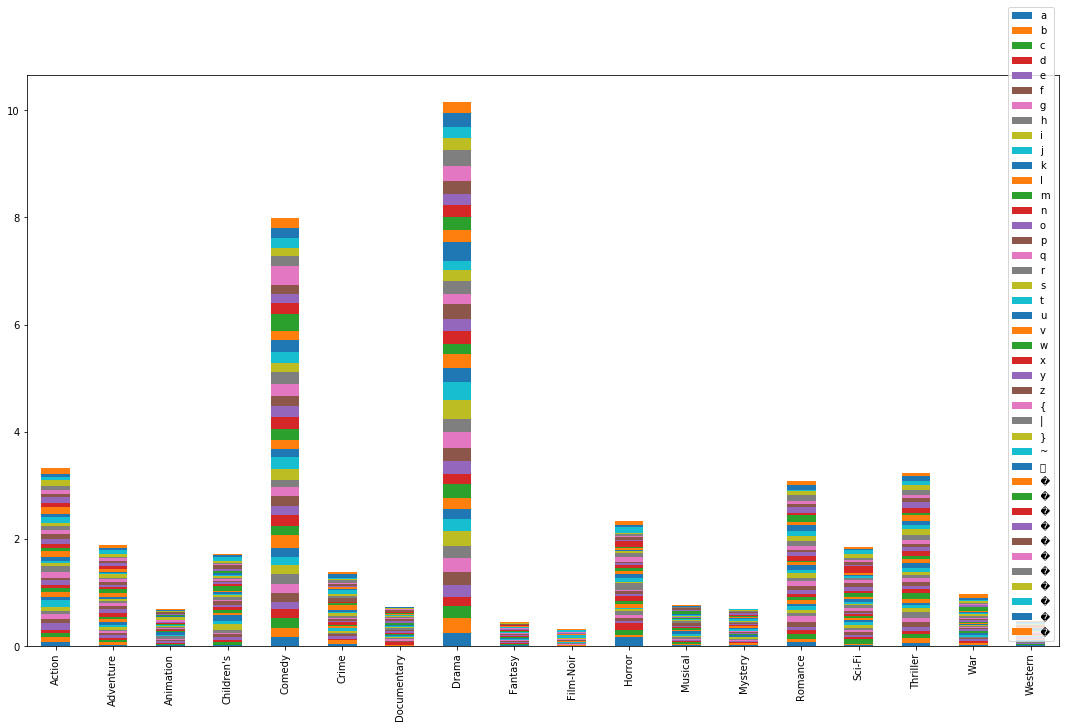

In [49]:
# plot
#
# Same content as plot above, but this time in form of "stacked bars"
#

tmp = zip(*d_list_list)
print tmp


#ix2 = pd.MultiIndex.from_arrays([[chr(97 + x) for x in xrange(21)]])
ix2 = all_genres


df2 = pd.DataFrame(tmp, columns=[chr(97 + x) for x in xrange(len(d_list_list))], index=ix2)

df2.plot.bar()
    
df2.plot.bar(stacked=True)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.show()


In [63]:
l1 = [1, 4, 7]
l2 = [2, 5, 8]
l3 = [3, 6, 9]
zip(l1, l2, l3)
zip(zip(l1, l2), l3)
zip(*[l1, l2, l3])

[(1, 2, 3), (4, 5, 6), (7, 8, 9)]